## Step 1 – Importing libraries required for Flight Price Prediction.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

## Step 2 – Reading training data. 

In [ ]:
train_data = pd.read_excel(r'Flight_Dataset\Data_Train.xlsx')
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Step 3 – Checking values in the Destination column.

In [ ]:
train_data['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

### Maximum people are going to Cochin followed by Bangalore and then Delhi in our dataset.

### Step 3.5 – Merging Delhi and New Delhi.

In [ ]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

### As we saw above our Destination had Delhi and New Delhi so we merged both of them.

## Step 4 – Checking info of our train data.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


------
- #### We will extract the journey day and journey month from the Date of the journey and make 2 columns for them as shown below.
- #### And then we will drop the Date of the journey column.

In [ ]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


## Step 6 – Extracting hours and minutes from time.


  -  As done above we will extract departure hour and departure minutes from departure time.
  - And same will be done for arrival time.
  - And after that, we will drop both columns.


In [ ]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

C:\Users\parth\AppData\Local\Temp\ipykernel_2916\4113259681.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
C:\Users\parth\AppData\Local\Temp\ipykernel_2916\4113259681.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
C:\Users\parth\AppData\Local\Temp\ipykernel_2916\4113259681.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
C:\Users\parth\AppD

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


## Step 7 – Dropping the Duration column and extracting important info from it.

In [ ]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

    
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


## Step 8 – Plotting Airline vs Price.

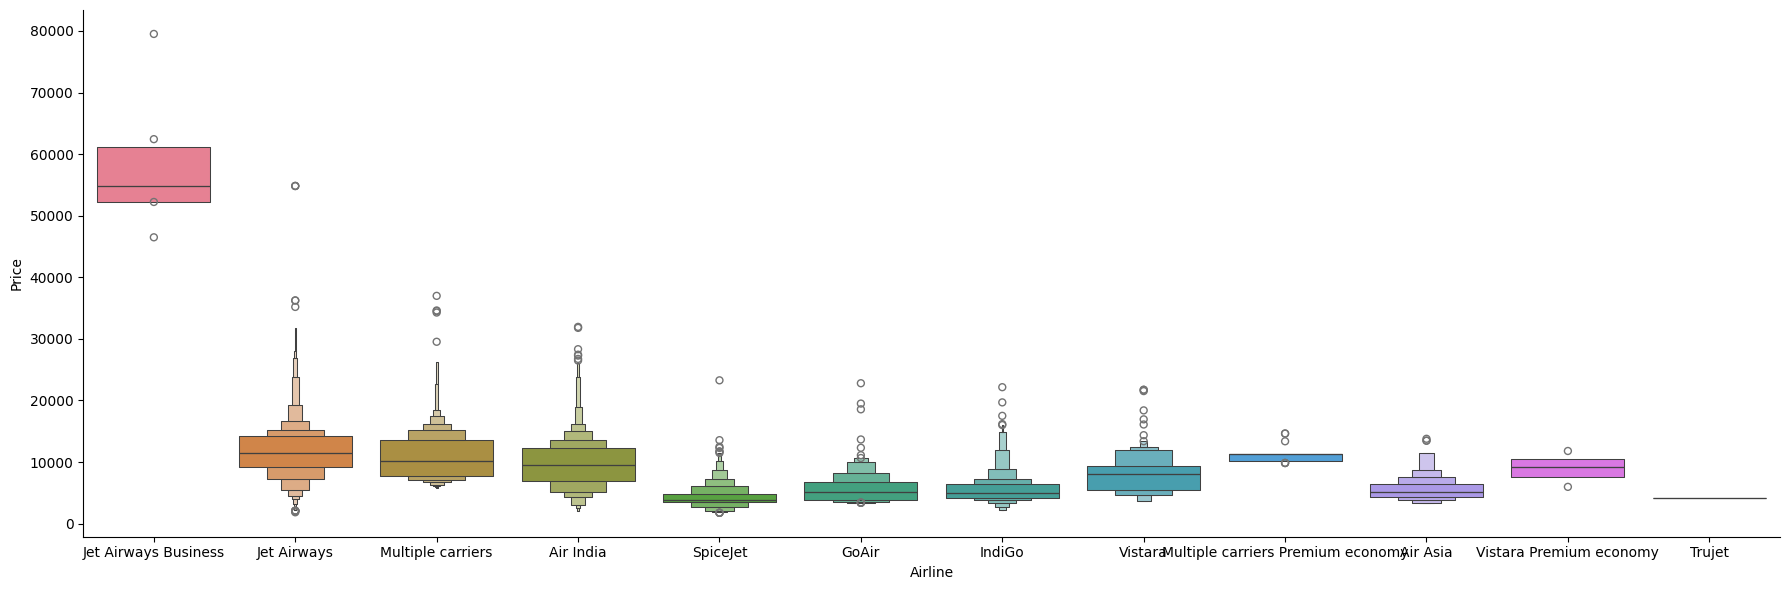

In [ ]:
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6, hue='Airline', legend=False)

### From the plot below we can infer that Jet Airways business is the costliest airways.

## Step 9 – Plotting Source vs Price.

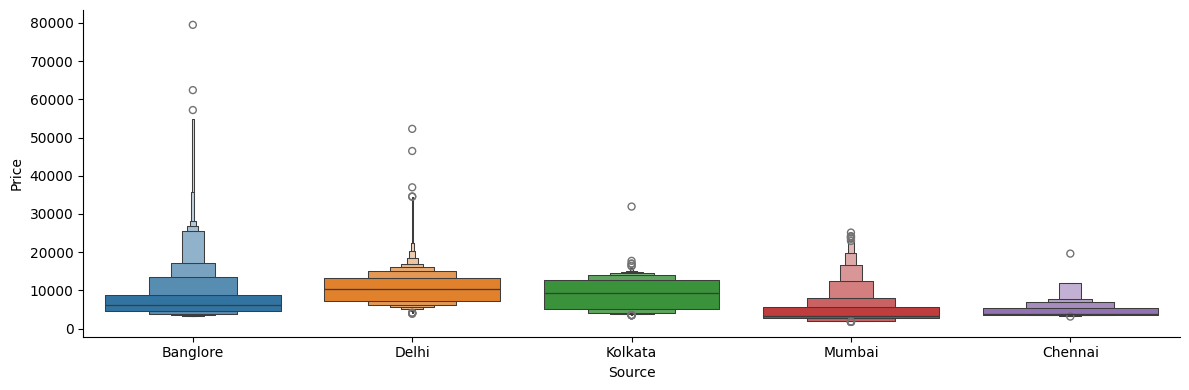

In [ ]:
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4, hue='Source')

### The plot below says that if you are going from Bangalore, no matter where you have to pay the highest amount of money.

## Step 10 – Plotting Destination vs Price.

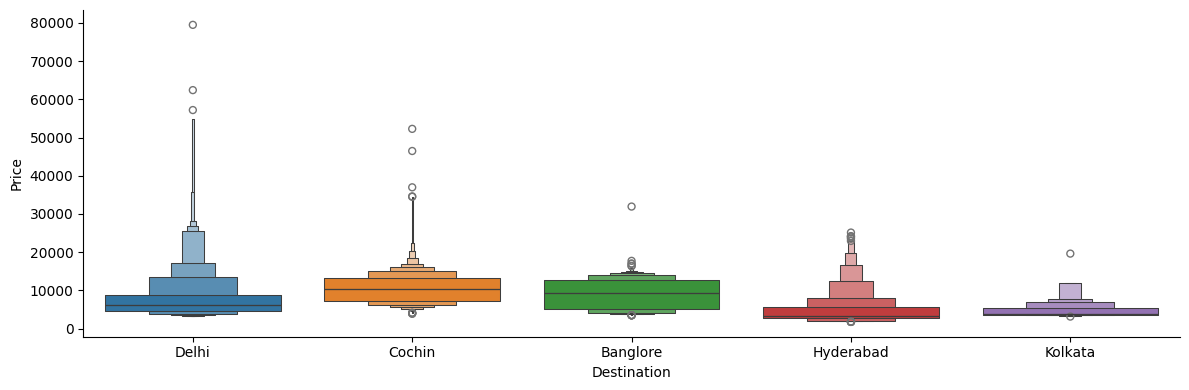

In [ ]:
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4, hue='Destination')

### The plot below says that if you are going to New Delhi, no matter from where, you have to pay the highest amount of money.


## Step 11 – Dropping crap columns.

In [ ]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Airline         10682 non-null  object
 1   Source          10682 non-null  object
 2   Destination     10682 non-null  object
 3   Total_Stops     10682 non-null  object
 4   Price           10682 non-null  int64 
 5   Journey_day     10682 non-null  int32 
 6   Journey_month   10682 non-null  int32 
 7   Dep_hour        10682 non-null  int32 
 8   Dep_min         10682 non-null  int32 
 9   Arrival_hour    10682 non-null  int32 
 10  Arrival_min     10682 non-null  int32 
 11  Duration_hours  10682 non-null  int64 
 12  Duration_mins   10682 non-null  int64 
dtypes: int32(6), int64(3), object(4)
memory usage: 918.0+ KB


## Step 12 - Encoding Categorical Values into Integer Values

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
train_data['Airline'] = encoder.fit_transform(train_data['Airline'])
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,3,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,1,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,4,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,3,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,3,Banglore,Delhi,1 stop,13302,1,3,16,50,21,35,4,45


In [ ]:
for category, integer in zip(encoder.classes_, range(len(encoder.classes_))):
    
    print(f"Value: {category}, Assigned Integer: {integer}")

Value: Air Asia, Assigned Integer: 0
Value: Air India, Assigned Integer: 1
Value: GoAir, Assigned Integer: 2
Value: IndiGo, Assigned Integer: 3
Value: Jet Airways, Assigned Integer: 4
Value: Jet Airways Business, Assigned Integer: 5
Value: Multiple carriers, Assigned Integer: 6
Value: Multiple carriers Premium economy, Assigned Integer: 7
Value: SpiceJet, Assigned Integer: 8
Value: Trujet, Assigned Integer: 9
Value: Vistara, Assigned Integer: 10
Value: Vistara Premium economy, Assigned Integer: 11


In [ ]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,3,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,1,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,4,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,3,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,3,Banglore,Delhi,1 stop,13302,1,3,16,50,21,35,4,45


In [ ]:
train_data['Source'] = encoder.fit_transform(train_data['Source'])
train_data['Destination'] = encoder.fit_transform(train_data['Destination'])
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,3,0,2,non-stop,3897,24,3,22,20,1,10,2,50
1,1,3,0,2 stops,7662,1,5,5,50,13,15,7,25
2,4,2,1,2 stops,13882,9,6,9,25,4,25,19,0
3,3,3,0,1 stop,6218,12,5,18,5,23,30,5,25
4,3,0,2,1 stop,13302,1,3,16,50,21,35,4,45


In [ ]:
for category, integer in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"Value: {category}, Assigned Integer: {integer}")

Value: Banglore, Assigned Integer: 0
Value: Cochin, Assigned Integer: 1
Value: Delhi, Assigned Integer: 2
Value: Hyderabad, Assigned Integer: 3
Value: Kolkata, Assigned Integer: 4


In [ ]:
train_data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [ ]:
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

C:\Users\parth\AppData\Local\Temp\ipykernel_2916\3018696578.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
C:\Users\parth\AppData\Local\Temp\ipykernel_2916\3018696578.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,3,0,2,0,3897,24,3,22,20,1,10,2,50
1,1,3,0,2,7662,1,5,5,50,13,15,7,25
2,4,2,1,2,13882,9,6,9,25,4,25,19,0
3,3,3,0,1,6218,12,5,18,5,23,30,5,25
4,3,0,2,1,13302,1,3,16,50,21,35,4,45


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Airline         10682 non-null  int64
 1   Source          10682 non-null  int64
 2   Destination     10682 non-null  int64
 3   Total_Stops     10682 non-null  int64
 4   Price           10682 non-null  int64
 5   Journey_day     10682 non-null  int32
 6   Journey_month   10682 non-null  int32
 7   Dep_hour        10682 non-null  int32
 8   Dep_min         10682 non-null  int32
 9   Arrival_hour    10682 non-null  int32
 10  Arrival_min     10682 non-null  int32
 11  Duration_hours  10682 non-null  int64
 12  Duration_mins   10682 non-null  int64
dtypes: int32(6), int64(7)
memory usage: 918.0 KB


In [ ]:
train_data.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Price',
       'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min', 'Arrival_hour',
       'Arrival_min', 'Duration_hours', 'Duration_mins'],
      dtype='object')

## Step 13 – Taking out train data.

In [ ]:
X = train_data.drop('Price',axis=1)
X.head()

,Airline,Source,Destination,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,3,0,2,0,24,3,22,20,1,10,2,50
1,1,3,0,2,1,5,5,50,13,15,7,25
2,4,2,1,2,9,6,9,25,4,25,19,0
3,3,3,0,1,12,5,18,5,23,30,5,25
4,3,0,2,1,1,3,16,50,21,35,4,45


## Step 14 – Take out train data labels.

In [ ]:
y = train_data['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

## Step 15 – Checking correlations between columns.

<Axes: >

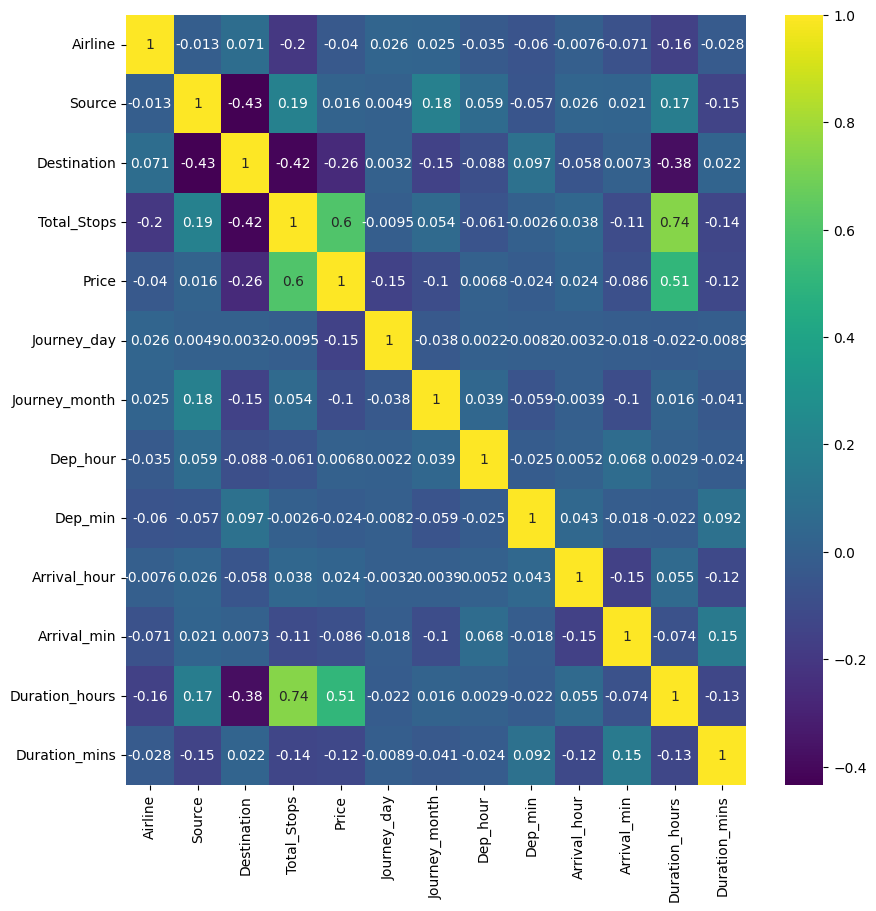

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

## Step 16 – First try out the ExtraTreesRegressor model for Flight Price Prediction.
- ### Let’s fit our data into ExtraTreeRegressor and analyze the feature importances.

In [ ]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[0.14940267 0.02386844 0.04376829 0.26389094 0.15057986 0.06659399
 0.02834684 0.02678189 0.03329776 0.02488477 0.16813902 0.02044553]


## Step 17 – Checking feature importance given by ExtraTreeRegressor.

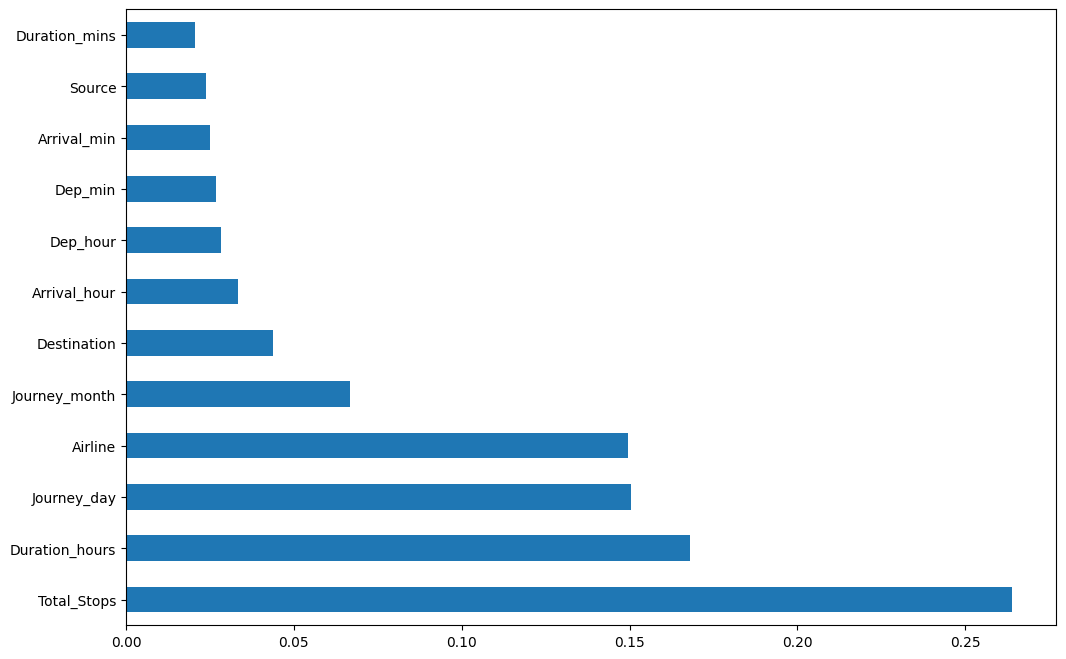

In [ ]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


- #### Total_stops is the feature with the highest feature importance in deciding the Price as we have also seen above.
- #### After that Duration and Journey Day also play a big role in deciding the Price. Prices are generally higher on weekends.


## Step 18 – Splitting our data into Training and Testing data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Step 19 – Training Random Forest Regressor model for Flight Price Prediction.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\parth\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\parth\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\parth\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\parth\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    validat

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

 -  Here we are using RandomizedSearchCV which just randomly tries out combinations and sees which one is the best out of them.
-  We have declared the parameters of RandomForestRegressor which we want to try.
-  We have also declared the range of values for each parameter which we want to try out.

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

## Step 20 – Taking Predictions

In [ ]:
prediction = rf_random.predict(X_test)

## Step 21 – Plotting the residuals.

<Figure size 800x800 with 0 Axes>

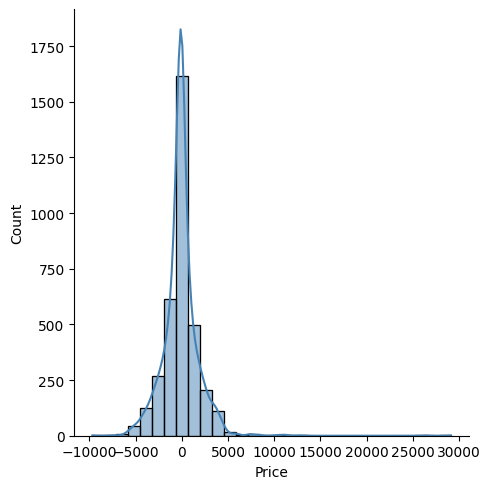

In [ ]:
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction, kde = True, color = 'steelblue', bins=30)
plt.show()

- As we can see that most of the residuals are 0, which means our model is generalizing well.

## Step 22 – Plotting y_test vs predictions.
-     Simply plotting our predictions vs the true values.
-     Ideally, it should be a straight line.

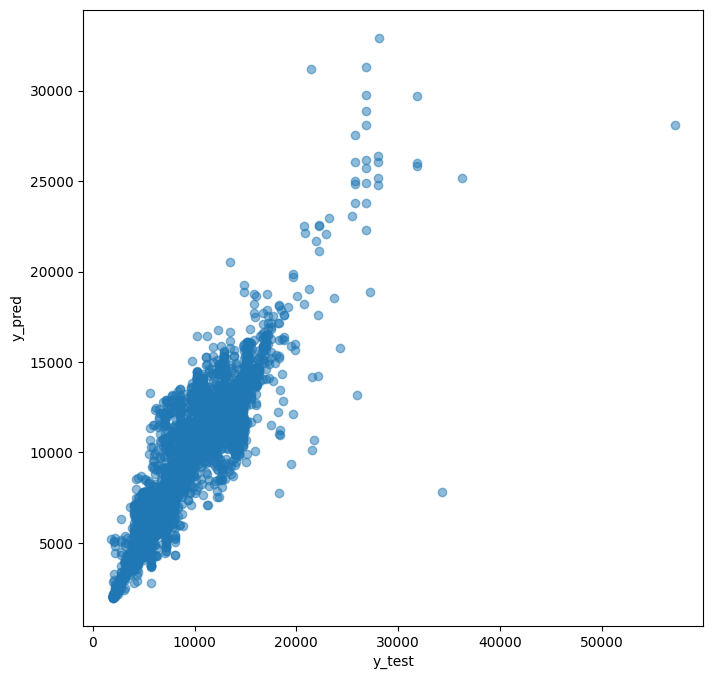

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.8148008921298138


## Step 23 – Saving our model. 

In [ ]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)